# Gravity Model PPML Estimation

## Formalization of the gravity model equation
### with origin-destination (importer-exporter) fixed effects and lagged independent variables

\begin{equation}
\begin{split}
EXPORT_{ij,t} =\; &\exp\Bigl[\hat{\alpha}_{ij}
+ \sum_{k=1}^5 \hat{\beta}_{1k}\,GDP_{i,t-k}
+ \sum_{l=1}^5 \hat{\beta}_{2l}\,GDP_{j,t-l} \\
&\quad
+ \sum_{m=1}^5 \hat{\beta}_{3m}\,SANCT_{ij,t-m}\Bigr]
\times \epsilon_{ij,t}
\end{split}
\end{equation}

Where:
- $\hat\alpha_{ij}$ - time-invariant fixed effects
- $GDP_{i,t}$ - size of origin country $i$ at time $t$
- $GDP_{j,t}$ - size of destination country $j$ at time $t$
- $SANCT_{ij,t}$ - unilateral sanction relationship $i \rightarrow j$ at time $t$
- $\hat\beta_{1k}$, $\hat\beta_{2l}$, $\hat\beta_{3m}$ - estimated coefficients for the respective lagged variables
- $\epsilon_{ij,t}$ - error term


In [103]:
import gme
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from celer import Lasso, LassoCV
from pandas import DataFrame
from scipy import sparse
from sklearn.model_selection import GroupShuffleSplit

import thesis_utils as tu

In [104]:
# Config for saving outputs
SAVE_ENABLED = True
SERIAL_NUMBER = "NOT_SET"
VERBOSE = 0

# Model parameters
N_LAGS = 5
N_DYADS = 5000
MAX_ITERATIONS = 5000
SUBSAMPLE_ENABLED = False

# Train parameters
TARGET = "EXPORT"
RANDOM_SEED = 16

SANCTION_COLS = ["arms", "military", "trade", "travel", "other"]

In [105]:
processed = pd.read_parquet(path="../../data/model/processed.parquet", engine="fastparquet")
df: DataFrame = processed.copy(deep=True)

In [106]:
# Sort data by Report + Partner + Year
df["dyad_id"] = df["ISO3_reporter"] + "_" + df["ISO3_partner"]
df = df.sort_values(by=["dyad_id", "Year"]).reset_index(drop=True)

In [107]:
if SUBSAMPLE_ENABLED:
  dyad_subsample = pd.Series(df["dyad_id"].unique()).sample(n=N_DYADS, random_state=RANDOM_SEED, replace=False)
  df = df[df["dyad_id"].isin(dyad_subsample)]
print(df["dyad_id"].nunique())

5000


In [108]:
df["GDP_reporter"] = np.log1p(df["GDP_reporter"]).astype(float)
df["GDP_partner"] = np.log1p(df["GDP_partner"]).astype(float)
df["EXPORT"] = np.log1p(df["EXPORT"])
df["sanction"] = (df[SANCTION_COLS]
                  .sum(axis=1)).astype(int)
df["distw"] = np.log1p(df["distw"]).astype(float)

In [109]:
# Coerce numerical values
num_cols = ["distw", "GDP_reporter", "GDP_partner", "sanction", "contig",
            "comlang_off", "colony", "smctry", "Year", ]
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce").astype(float)
df = df.dropna(subset=num_cols)

In [110]:
lag_cols = ["GDP_reporter", "GDP_partner", "sanction"]
invariant_cols = ["contig", "comlang_off", "colony", "smctry", "distw"]

In [111]:
for col in lag_cols:
  for index in range(1, N_LAGS + 1):
    df[f"{col}_lag{index}"] = df.groupby("dyad_id")[col].shift(index)

df = df.dropna()

df["Year"] = df["Year"].astype(int)
for col in ["dyad_id"]:
  df[col] = pd.Categorical(df[col], categories=sorted(df[col].unique()))

In [112]:
df = tu.add_fixed_effects(df)

Df Shape:  (150003, 45)
Dummies Shape:  (150003, 4999)
Final Df Shape:  (150003, 5044)


In [113]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)

train_df_idx, test_df_idx = next(gss.split(df, groups=df["dyad_id"]))
test_df = df.iloc[test_df_idx]
train_df = df.iloc[train_df_idx]

In [114]:
rhs_cols = [f"{c}_lag{index}" for c in lag_cols for index in range(1, N_LAGS + 1)]
fe_columns = [col for col in train_df.columns if col.startswith("fe_dyad_id_")]
convert_to_float_columns = rhs_cols + invariant_cols
train_df.loc[:, convert_to_float_columns] = train_df.loc[:, convert_to_float_columns].astype(
  "float32",
  copy=False
)
rhs_cols = rhs_cols + invariant_cols + fe_columns

print("Fixed effects columns:", fe_columns[:10])
print("Lagged columns:", rhs_cols[:15])

Fixed effects columns: ['fe_dyad_id_AGO_ARM', 'fe_dyad_id_AGO_BEL', 'fe_dyad_id_AGO_BGD', 'fe_dyad_id_AGO_CMR', 'fe_dyad_id_AGO_CRI', 'fe_dyad_id_AGO_DJI', 'fe_dyad_id_AGO_GRD', 'fe_dyad_id_AGO_IDN', 'fe_dyad_id_AGO_IRN', 'fe_dyad_id_AGO_ISL']
Lagged columns: ['GDP_reporter_lag1', 'GDP_reporter_lag2', 'GDP_reporter_lag3', 'GDP_reporter_lag4', 'GDP_reporter_lag5', 'GDP_partner_lag1', 'GDP_partner_lag2', 'GDP_partner_lag3', 'GDP_partner_lag4', 'GDP_partner_lag5', 'sanction_lag1', 'sanction_lag2', 'sanction_lag3', 'sanction_lag4', 'sanction_lag5']


In [115]:
# Prepare data
print("Selecting columns based on rhs_cols...")
col_idx = [train_df.columns.get_loc(c) for c in rhs_cols]
print("Finished extracting raw features.")

Selecting columns based on rhs_cols...
Finished extracting raw features.


In [116]:
print("Extracting features from train_df...", flush=True)
X = train_df.iloc[:, col_idx].to_numpy(dtype=float, copy=False)
print("Finished extracting features.")
print("Creating sparse matrix from features...")
X = sparse.csr_matrix(X, dtype=float)
print("Finished creating sparse matrix from features.")

Extracting features from train_df...
Finished extracting features.
Creating sparse matrix from features...
Finished creating sparse matrix from features.


In [117]:
y = train_df["EXPORT"].to_numpy(dtype=np.float32)
print("Finished extracting target variable.")

Finished extracting target variable.


In [118]:
# 1) Cross-validated Lasso to pick alpha
lasso_cv = LassoCV(cv=5, max_iter=MAX_ITERATIONS, tol=1e-4,
                   verbose=VERBOSE, n_jobs=-1)
print("Fitting celer.LassoCV (5-fold, all CPUs)…")
lasso_cv.fit(X, y)
cv_coef = lasso_cv.coef_

Fitting celer.LassoCV (5-fold, all CPUs)…


In [119]:
# Scale down the chosen alpha if desired
best_alpha = lasso_cv.alpha_
print(f"Selected alpha from CV: {best_alpha:.3e}")

Selected alpha from CV: 7.709e-03


In [120]:
# 2) Build threshold grid from non-zero CV coefficients
nz = np.abs(cv_coef[cv_coef != 0])
if nz.size == 0:
  print("Warning: no non-zero coefficients found! Using fallback.")
  nz = np.array([1e-5])
min_c, max_c = nz.min(), nz.max()
threshold_grid = np.logspace(np.log10(min_c / 10),
                             np.log10(max_c / 10), 10)
print("Threshold grid:", threshold_grid)

# 3) Fit final Lasso at best_alpha
print("Fitting final celer.Lasso…")
lasso_full = Lasso(alpha=best_alpha, max_iter=MAX_ITERATIONS,
                   tol=1e-4,
                   verbose=VERBOSE)
lasso_full.fit(X, y)
full_coef = lasso_full.coef_

Threshold grid: [0.00274779 0.00423239 0.00651909 0.01004127 0.01546644 0.02382275
 0.03669387 0.05651908 0.08705559 0.13409056]
Fitting final celer.Lasso…


In [121]:
# 4) Loop over thresholds, refit on selected features, and compute RMSE
results_threshold = {
  "thresholds": [],
  "errors": [],
  "n_columns": [],
  "selected_columns": []
}

for thr in threshold_grid:
  print(f"\nThreshold {thr:.5f}")
  idx = np.where(np.abs(full_coef) >= thr)[0]
  cols = [rhs_cols[i] for i in idx]
  print(f"  -> {len(cols)} features selected")

  Xr = X[:, idx]
  lasso_sub = Lasso(alpha=best_alpha, max_iter=MAX_ITERATIONS,
                    tol=1e-4, verbose=VERBOSE)
  lasso_sub.fit(Xr, y)
  y_pred = lasso_sub.predict(Xr)
  err = tu.rmse(y, y_pred)

  results_threshold["thresholds"].append(thr)
  results_threshold["errors"].append(err)
  results_threshold["n_columns"].append(len(cols))
  results_threshold["selected_columns"].append(cols)


Threshold 0.00275
  -> 13 features selected

Threshold 0.00423
  -> 13 features selected

Threshold 0.00652
  -> 13 features selected

Threshold 0.01004
  -> 13 features selected

Threshold 0.01547
  -> 13 features selected

Threshold 0.02382
  -> 13 features selected

Threshold 0.03669
  -> 11 features selected

Threshold 0.05652
  -> 10 features selected

Threshold 0.08706
  -> 9 features selected

Threshold 0.13409
  -> 7 features selected


In [122]:
best_idx = np.argmin(results_threshold["errors"])

best_rmse = results_threshold["errors"][best_idx]
best_columns = results_threshold["selected_columns"][best_idx]

print(f"Best RMSE: {best_rmse}")
print(f"Best columns ({len(best_columns)}):")
print(best_columns)

Best RMSE: 3.2704871956053063
Best columns (10):
['GDP_reporter_lag1', 'GDP_reporter_lag5', 'GDP_partner_lag1', 'sanction_lag1', 'sanction_lag5', 'contig', 'comlang_off', 'colony', 'smctry', 'distw']


In [123]:
train_df.loc[:, 'ISO3_reporter'] = pd.Series(train_df['ISO3_reporter'].values, index=train_df.index).astype(str)
train_df.loc[:, 'ISO3_partner'] = pd.Series(train_df['ISO3_partner'].values, index=train_df.index).astype(str)
train_df.loc[:, 'Year'] = pd.to_numeric(train_df['Year'], errors='coerce')

In [124]:
for col in best_columns:
  train_df.loc[:, col] = pd.to_numeric(train_df[col], errors='coerce', downcast="float")

In [125]:
# Create estimation object
gme_data = gme.EstimationData(
  data_frame=train_df,
  imp_var_name="ISO3_reporter",
  exp_var_name="ISO3_partner",
  trade_var_name=TARGET,
  year_var_name="Year"
)
gme_data

number of countries: 184 
number of exporters: 184 
number of importers: 184 
number of years: 32 
number of sectors: not_applicable 
dimensions: (120003, 5044)

In [126]:
# Create GME model
gme_model = gme.EstimationModel(
  estimation_data=gme_data,
  lhs_var="EXPORT",
  rhs_var=best_columns,
  drop_intratrade=True
)

In [127]:
# Conduct PPML estimation of coefficients
estimates = gme_model.estimate()

Estimation began at 12:03 PM  on Jun 28, 2025
Omitted Regressors: []
Estimation completed at 12:03 PM  on Jun 28, 2025


In [128]:
gme_model.ppml_diagnostics

Overfit Warning                            No
Number of Regressors Dropped                0
Regressors with Zero Trade                 []
Regressors from User                       []
Regressors Perfectly Collinear             []
Completion Time                   0.0 minutes
dtype: object

In [129]:
# estimates.keys()
results = estimates['all']
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 EXPORT   No. Observations:               120003
Model:                            GLM   Df Residuals:                   119993
Model Family:                 Poisson   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.6592e+05
Date:                Sat, 28 Jun 2025   Deviance:                   5.0438e+05
Time:                        12:03:44   Pearson chi2:                 4.16e+05
No. Iterations:                     5   Pseudo R-squ. (CS):             0.9235
Covariance Type:                  HC1                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
GDP_reporter_lag1     0.2396      0.007     35.169      0.000       0.226       0.253
GDP_reporter_lag5    -0.0392      0.007     -5.787      0.000      -0.052      -0.026
GDP_partner_lag1      0.0684      0.001     73.418      0.000       0.067       0.070
sanction_lag1        -0.0605      0.005    -13.150      0.000      -0.070      -0.052
sanction_lag5        -0.0266      0.005     -5.705      0.000      -0.036      -0.017
contig               -0.5295      0.015    -34.198      0.000      -0.560      -0.499
comlang_off           0.0689      0.007      9.188      0.000       0.054       0.084
colony                0.2138      0.017     12.522      0.000       0.180       0.247
smctry               -0.2487      0.023    -10.842      0.000      -0.294      -0.204
distw                -0.5920      0.003   -229.093      0.000      -0.597      -0.587
=====================================================================================
"""

In [130]:
betas = results.params
betas

GDP_reporter_lag1    0.239575
GDP_reporter_lag5   -0.039179
GDP_partner_lag1     0.068365
sanction_lag1       -0.060537
sanction_lag5       -0.026559
contig              -0.529506
comlang_off          0.068879
colony               0.213818
smctry              -0.248730
distw               -0.591994
dtype: float64

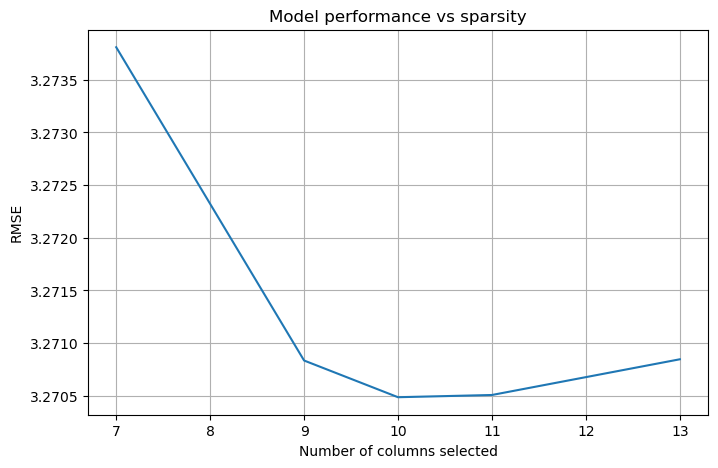

In [131]:
plt.figure(figsize=(8, 5))
plt.plot(results_threshold["n_columns"], results_threshold["errors"])
plt.xlabel("Number of columns selected")
plt.ylabel("RMSE")
plt.title("Model performance vs sparsity")
plt.grid()
plt.show()

In [132]:
betas = gme_model.results_dict["all"].params

for col in best_columns:
  test_df.loc[:, col] = pd.to_numeric(test_df[col], errors="coerce")
test_df = test_df.dropna(subset=best_columns)
model_columns = betas.index.tolist()

In [133]:
missing_cols = [col for col in model_columns if col not in test_df.columns]
if missing_cols:
  print(f"Warning: The following columns are missing in test_df: {missing_cols}")
  for col in missing_cols:
    test_df[col] = 0.0

In [134]:
X_test = test_df[model_columns].values
beta_values = betas[model_columns].values
linear_combination = X_test @ beta_values
test_df["EXPORT_hat"] = np.exp(linear_combination)

In [135]:
y_true = test_df["EXPORT"].values
y_pred = test_df["EXPORT_hat"].values

print(f"RMSE: {tu.rmse(y_true, y_pred):.4f}")
print(f"MAE: {tu.mae(y_true, y_pred):.4f}")
print(f"RMAE: {tu.rmae(y_true, y_pred):.4f}")
print(f"Pseudo R²: {tu.pseudo_r2(y_true, y_pred):.4f}")
print(f"Within R²: {tu.within_r2(y_true, y_pred, test_df['dyad_id'].values):.4f}")

RMSE: 3.8285
MAE: 3.0210
RMAE: 0.7669
Pseudo R²: 0.3783
Within R²: -2.2453


In [136]:
# Save betas
beta_df = pd.DataFrame(beta_values, index=model_columns, columns=["beta"])
beta_df.to_csv("../../models/ppml_beta_values.csv")